In [12]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Data preparation

In [70]:
data0 = pd.read_csv("/home/iuliiasolomennikova/Desktop/ITMO_ML/ML_ITMO/Smoker_Epigenetic_df.csv")
data0

,GSM,Smoking Status,Gender,Age,cg00050873,cg00212031,cg00213748,cg00214611,cg00455876,cg01707559,...,cg02494853,cg02839557,cg02842889,cg03052502,cg03155755,cg03244189,cg03443143,cg03683899,cg03695421,cg03706273
0,GSM1051525,current,f,67,0.607563,0.422843,0.372455,0.621562,0.290777,0.267143,...,0.067070,0.246993,0.469240,0.400247,0.415031,0.221433,0.475826,0.207724,0.209197,0.129983
1,GSM1051526,current,f,49,0.345054,0.568662,0.500600,0.498607,0.374591,0.190274,...,0.046939,0.236742,0.307467,0.377031,0.397371,0.217122,0.544469,0.184446,0.193773,0.098533
2,GSM1051527,current,f,53,0.321350,0.360909,0.352732,0.373824,0.230674,0.314705,...,0.038237,0.244612,0.357753,0.305044,0.521278,0.185049,0.537060,0.393123,0.268003,0.040248
3,GSM1051528,current,f,62,0.277268,0.304437,0.475235,0.486258,0.295181,0.295793,...,0.026716,0.001641,0.445739,0.271475,0.434492,0.165419,0.507917,0.281209,0.217857,0.101516
4,GSM1051529,never,f,33,0.413599,0.131251,0.367545,0.761167,0.235770,0.250526,...,0.037016,0.334320,0.395040,0.326553,0.430097,0.181135,0.405479,0.310794,0.280071,0.077857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,GSM2219547,current,M,74,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
679,GSM2219548,current,M,75,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
680,GSM2219548,current,M,75,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
681,GSM2219549,current,M,75,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
data0['Gender'] = data0['Gender'].map({' f':0,' m':1,' F':0,' M':1}).astype(int)
data0.head()

,GSM,Smoking Status,Gender,Age,cg00050873,cg00212031,cg00213748,cg00214611,cg00455876,cg01707559,...,cg02494853,cg02839557,cg02842889,cg03052502,cg03155755,cg03244189,cg03443143,cg03683899,cg03695421,cg03706273
0,GSM1051525,current,0,67,0.607563,0.422843,0.372455,0.621562,0.290777,0.267143,...,0.067070,0.246993,0.469240,0.400247,0.415031,0.221433,0.475826,0.207724,0.209197,0.129983
1,GSM1051526,current,0,49,0.345054,0.568662,0.500600,0.498607,0.374591,0.190274,...,0.046939,0.236742,0.307467,0.377031,0.397371,0.217122,0.544469,0.184446,0.193773,0.098533
2,GSM1051527,current,0,53,0.321350,0.360909,0.352732,0.373824,0.230674,0.314705,...,0.038237,0.244612,0.357753,0.305044,0.521278,0.185049,0.537060,0.393123,0.268003,0.040248
3,GSM1051528,current,0,62,0.277268,0.304437,0.475235,0.486258,0.295181,0.295793,...,0.026716,0.001641,0.445739,0.271475,0.434492,0.165419,0.507917,0.281209,0.217857,0.101516
4,GSM1051529,never,0,33,0.413599,0.131251,0.367545,0.761167,0.235770,0.250526,...,0.037016,0.334320,0.395040,0.326553,0.430097,0.181135,0.405479,0.310794,0.280071,0.077857


In [19]:
n=len(data0)
n

683

In [20]:
N=[]
for i in range(n):
    N+=[i]
random.shuffle(N)

name=sorted(data0['Smoking Status'].unique())
name

['current', 'never']

In [21]:
N=[]
for i in range(2):
    N+=[i]
    
normal_mapping=dict(zip(name,N )) 
reverse_mapping=dict(zip(N,name)) 

def mapper(value):
    return reverse_mapping[value]

print(normal_mapping)

{'current': 0, 'never': 1}


# Target setting

In [28]:
datay0=data0['Smoking Status'].map(normal_mapping) #predict Smoking Status
datax0=data0.drop(['Smoking Status','GSM'],axis=1)
datax0.head()

,Gender,Age,cg00050873,cg00212031,cg00213748,cg00214611,cg00455876,cg01707559,cg02004872,cg02011394,...,cg02494853,cg02839557,cg02842889,cg03052502,cg03155755,cg03244189,cg03443143,cg03683899,cg03695421,cg03706273
0,0,67,0.607563,0.422843,0.372455,0.621562,0.290777,0.267143,0.179144,0.480252,...,0.067070,0.246993,0.469240,0.400247,0.415031,0.221433,0.475826,0.207724,0.209197,0.129983
1,0,49,0.345054,0.568662,0.500600,0.498607,0.374591,0.190274,0.155977,0.418081,...,0.046939,0.236742,0.307467,0.377031,0.397371,0.217122,0.544469,0.184446,0.193773,0.098533
2,0,53,0.321350,0.360909,0.352732,0.373824,0.230674,0.314705,0.105745,0.615103,...,0.038237,0.244612,0.357753,0.305044,0.521278,0.185049,0.537060,0.393123,0.268003,0.040248
3,0,62,0.277268,0.304437,0.475235,0.486258,0.295181,0.295793,0.111286,0.301020,...,0.026716,0.001641,0.445739,0.271475,0.434492,0.165419,0.507917,0.281209,0.217857,0.101516
4,0,33,0.413599,0.131251,0.367545,0.761167,0.235770,0.250526,0.169108,0.392975,...,0.037016,0.334320,0.395040,0.326553,0.430097,0.181135,0.405479,0.310794,0.280071,0.077857


In [29]:
datax2=np.array(datax0)
datay2=np.array(datay0)

m=len(datax2)
M=[]
for i in range(m):
    M+=[i]
random.shuffle(M)

# Train and test setting

In [31]:
train=datax2[M[0:(n//10)*8]]
test=datax2[M[(n//10)*8:]]
trainy=datay2[M[0:(n//10)*8]]
testy=datay2[M[(n//10)*8:]]

In [32]:
df_columns = [ 'Gender', 'Age', 'cg00050873', 'cg00212031', 'cg00213748', 
    'cg00214611', 'cg00455876', 'cg01707559', 'cg02004872', 'cg02011394',        
    'cg02050847', 'cg02233190', 'cg02494853', 'cg02839557', 'cg02842889', 
    'cg03052502', 'cg03155755', 'cg03244189', 'cg03443143', 'cg03683899', 
    'cg03695421', 'cg03706273']

In [33]:
train_df=pd.DataFrame(train)
test_df=pd.DataFrame(test)

In [34]:
train_df.columns=df_columns
test_df.columns=df_columns

In [35]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [36]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [37]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [38]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 350.69it/s]


createcreate_numeric_feature  0.002[s]


100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 544.50it/s]

createcreate_numeric_feature  0.001[s]


# Model

In [39]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [40]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
}

In [41]:
y = trainy

In [44]:
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

fold = KFold(n_splits=10, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y))
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

fit fold=0  0.114[s]
Fold 0 RMSLE: 0.4189

fit fold=1  0.072[s]
Fold 1 RMSLE: 0.4564

fit fold=2  0.072[s]
Fold 2 RMSLE: 0.4003

fit fold=3  0.082[s]
Fold 3 RMSLE: 0.4167

fit fold=4  0.097[s]
Fold 4 RMSLE: 0.4112

fit fold=5  0.079[s]
Fold 5 RMSLE: 0.4642

fit fold=6  0.097[s]
Fold 6 RMSLE: 0.4520

fit fold=7  0.077[s]
Fold 7 RMSLE: 0.4660

fit fold=8  0.069[s]
Fold 8 RMSLE: 0.4301

fit fold=9  0.087[s]
Fold 9 RMSLE: 0.4305

--------------------------------------------------
FINISHED | Whole RMSLE: 0.4351


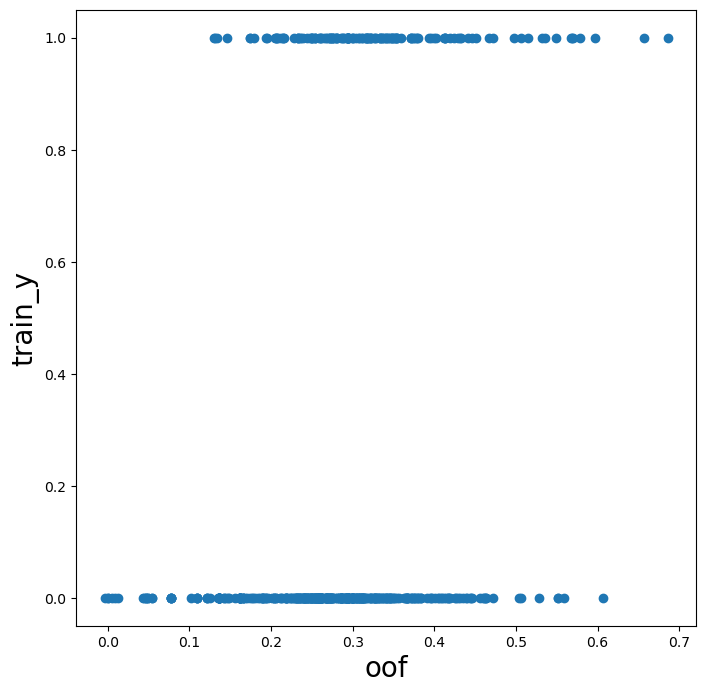

In [45]:
fig,ax = plt.subplots(figsize=(8,8))
ax.set_xlabel('oof',fontsize=20)
ax.set_ylabel('train_y',fontsize=20)
ax.scatter(oof,y)

# Visualize Importance

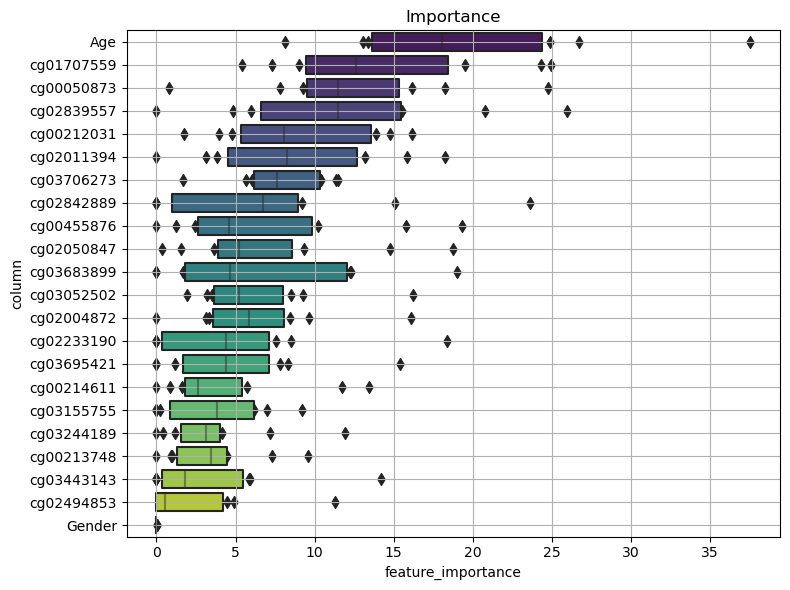

In [46]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=0)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig,ax

fig, ax = visualize_importance(models, train_feat_df)

### 'cg01707559' is the most imprtant factor for smokers among The CpG sites.

In [47]:
def revert_to_real(preda):
    predb = np.where(preda<0.5,0,1)
    return predb

# Predict

In [48]:
pred0 = np.array([model.predict(test_feat_df.values) for model in models])
pred1 = np.mean(pred0, axis=0)
pred2 = revert_to_real(pred1)
pred2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

### Metrics:

In [90]:
from sklearn.metrics import classification_report, log_loss, accuracy_score, confusion_matrix
from sklearn import metrics



accuracy=accuracy_score(testy,pred2)

print('accuracy for LightGBM:', accuracy )
print('---------------------------------------------------------')
print(classification_report(testy,pred2))
print('---------------------------------------------------------')
print('Cross-entropy loss for LightGBM:',log_loss(testy,pred2))
print('---------------------------------------------------------')

print('confusion_matrix:')
print()
print(confusion_matrix(testy,pred2))


accuracy for LightGBM: 0.7050359712230215
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        98
           1       0.00      0.00      0.00        41

    accuracy                           0.71       139
   macro avg       0.35      0.50      0.41       139
weighted avg       0.50      0.71      0.58       139

---------------------------------------------------------
Cross-entropy loss for LightGBM: 10.631581215494988
---------------------------------------------------------
confusion_matrix:

[[98  0]
 [41  0]]


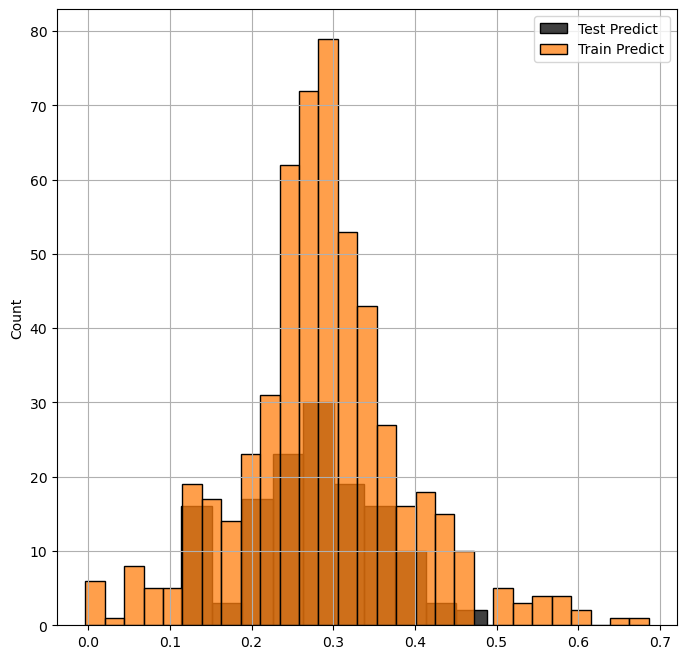

In [50]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(pred1, label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Train Predict', ax=ax, color='C1')
ax.legend()
ax.grid()